In [134]:
# Our numerical workhorse
import numpy as np
import scipy.special
import pandas as pd

# Import pyplot for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [118]:
def log_prior(mu, sigma, ranges):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a Jeffreys prior for sigma and uniform prior on mu_range for mu.
    """
    if sigma < 0.0 or mu < ranges['mu'][0] or mu > ranges['mu'][1]:
        return -np.inf
    else:
        return -np.log(sigma)


def log_likelihood(data, mu, sigma):
    """
    Log of the unnormalized likelihood for a single mu and sigma 
    for Gaussian distributed data.
    """
    n = len(data)
    return -((data - mu)**2).sum() / (2 * sigma**2) - n * np.log(sigma)


def log_posterior(log_likelihood_fun, log_prior_fun, data, mu, sigma, 
                  ranges, **kwargs):
    """
    Compute the log of the posterior, given an array of data, plus
    arrays of mu and sigma.  The functions defining the likelihood
    and prior are given by log_likelihood_fun and log_prior_fun, 
    respectively.
    
    Returns a 2D array of the posterior where entry i,j corresponds to
    mu[j], sigma[i].
    
    There are faster ways to calculate this, but we're doing it this way
    because we will use similar definitions when we do MCMC.
    """
    log_post = np.empty((len(sigma), len(mu)))
    for i, sig in enumerate(sigma):
        for j, m in enumerate(mu):
            if not kwargs:
                log_post[i, j] = log_likelihood_fun(data, m, sig) \
                                + log_prior_fun(m, sig, ranges)
            else:
                log_post[i, j] = log_likelihood_fun(data, m, sig) \
                                + log_prior_fun(m, sig, ranges,m=kwargs['m'],s=kwargs['s'])

    # Add a constant to log_post to get it close to unity so well-behaved
    # when we exponentiate it.  We don't care about normalization.
    log_post -= log_post.max()

    return log_post

## Problem 2.2a: Total number of sleep minutes

If a 'sleep minute' is a minute during which a fish has no activity, then we find the minutes each wt fish was asleep the third night by counting the minutes for each wt fish druing the third night when it's activity was 0. 

In [140]:
# load the data
df = pd.read_csv('data/130315_1_minute_intervals.csv',delimiter=',')

sleep_minutes = np.empty((17,1))
# loop through the WT fishies
WT_inds = df['genotype'] == 'wt'
for i,fish in enumerate(set(list(df[WT_inds]['fish']))):
    fish_inds = df['fish'] == fish
    day_inds = df['day'] == 3 
    night_inds = df['light'] == False
    sleep_inds = df['activity'] == 0
    sleep_minutes[i] = len(df[fish_inds & day_inds & night_inds & sleep_inds])
print (sleep_minutes)
print ("sample mean: ", str(np.mean(sleep_minutes)))
print ("sample standard deviation: ", str(np.std(sleep_minutes)))

[[ 324.]
 [ 236.]
 [ 296.]
 [ 302.]
 [ 294.]
 [ 244.]
 [ 199.]
 [ 126.]
 [ 325.]
 [ 271.]
 [ 378.]
 [ 261.]
 [ 350.]
 [ 181.]
 [ 239.]
 [ 284.]
 [ 253.]]
sample mean:  268.411764706
sample standard deviation:  61.0188580528


## 2.2b Computing the posterior distribution and most likely values 

In [119]:
# Ranges to sample parameters
mu = np.linspace(150.0, 350., 200)
sigma = np.linspace(20., 100.0, 200)

# Assume mu uniform on 0 < mu < 600
ranges = {}
ranges['mu'] = (150., 350.)

# Compute the posterior
log_post = log_posterior(log_likelihood, log_prior, sleep_minutes, mu, sigma, ranges)

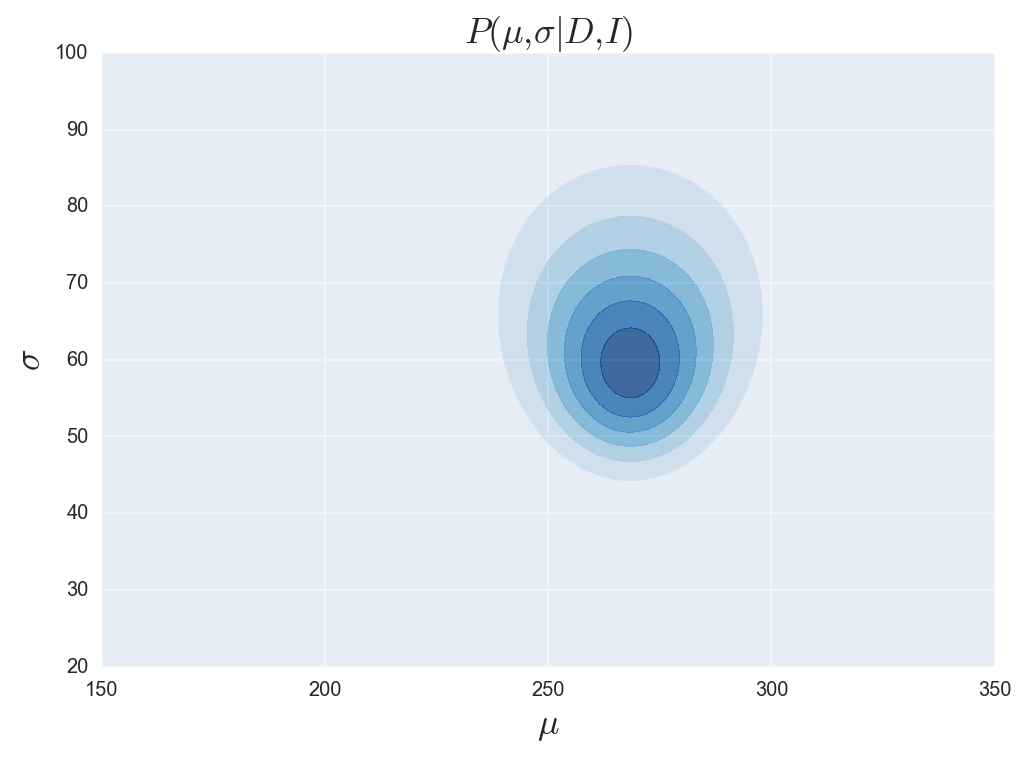

In [112]:
# Use contourf with Blues colormap.
plt.contourf(mu, sigma, np.exp(log_post), cmap=plt.cm.Blues, alpha=0.75)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'$P(\mu,\sigma|D,I)$');

In [120]:
# Approximate most probable value of mu and sigma
most_prob_inds = np.unravel_index(log_post.argmax(), log_post.shape)
mu_most_prob = mu[most_prob_inds[1]]
sigma_most_prob = sigma[most_prob_inds[0]]

print('most probable mu    = {0:.3f}'.format(mu_most_prob))
print('most probable sigma = {0:.3f}'.format(sigma_most_prob))

most probable mu    = 268.593
most probable sigma = 59.397


## 2.2c Using a uniform prior

In [121]:
def log_prior_uniform(mu, sigma, ranges):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a uniform prior on sigma_range for sigma and uniform prior on mu_range for mu.
    """
    if sigma < ranges['sigma'][0] or sigma > ranges['sigma'][1] or mu < ranges['mu'][0] or mu > ranges['mu'][1]:
        return -np.inf
    else:
        return 2 # the constant doesn't matter...

In [102]:
# Assume mu uniform on 0 < mu < 600
ranges['sigma'] = [20,100]

# Compute the posterior
log_post_uniform = log_posterior(log_likelihood, log_prior_uniform, sleep_minutes, mu, sigma, ranges)

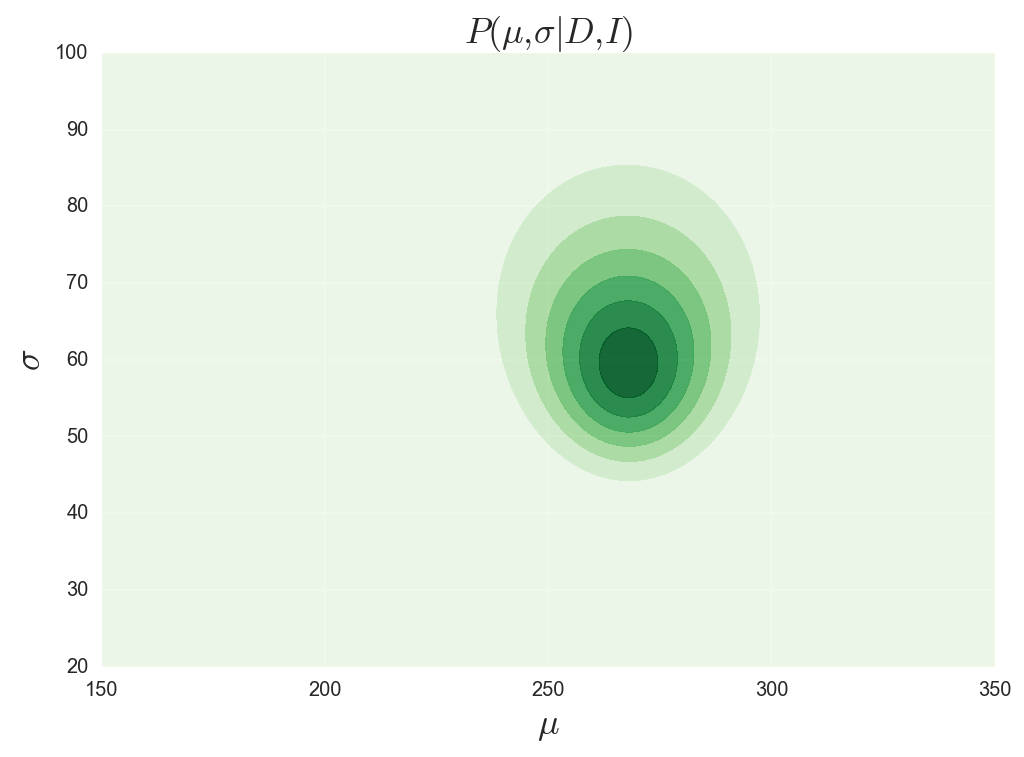

In [88]:
# Use contourf with Greens colormap.
plt.contourf(mu, sigma, np.exp(log_post_uniform), cmap=plt.cm.Greens, alpha=0.9)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'$P(\mu,\sigma|D,I)$');

In [103]:
# Approximate most probable value of mu and sigma
most_prob_inds = np.unravel_index(log_post_uniform.argmax(), log_post_uniform.shape)
mu_most_prob = mu[most_prob_inds[1]]
sigma_most_prob = sigma[most_prob_inds[0]]

print('most probable mu    = {0:.3f}'.format(mu_most_prob))
print('most probable sigma = {0:.3f}'.format(sigma_most_prob))

most probable mu    = 268.593
most probable sigma = 61.005


Because the Jeffrey's prior penalizes large values of sigma and the uniform prior does not, this posterior is slightly more favorable to larger values of sigma. The difference is not very large because the data mostly overwhelm the prior in both cases. 

## 2.2d Gaussian prior for mu

In [123]:
def log_prior_gaussian(mu, sigma, ranges, m=225, s =150):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a Jeffreys prior for sigma and gaussian prior on for mu with mean m and standard deviation s
    """
    if sigma < mu < ranges['mu'][0] or mu > ranges['mu'][1]:
        return -np.inf
    else:
        return -(m - mu)**2 / (2 * s**2) - np.log(sigma)

In [124]:
# Compute the posterior
log_post_gaussian = log_posterior(log_likelihood, log_prior_gaussian, sleep_minutes, mu, sigma, ranges)

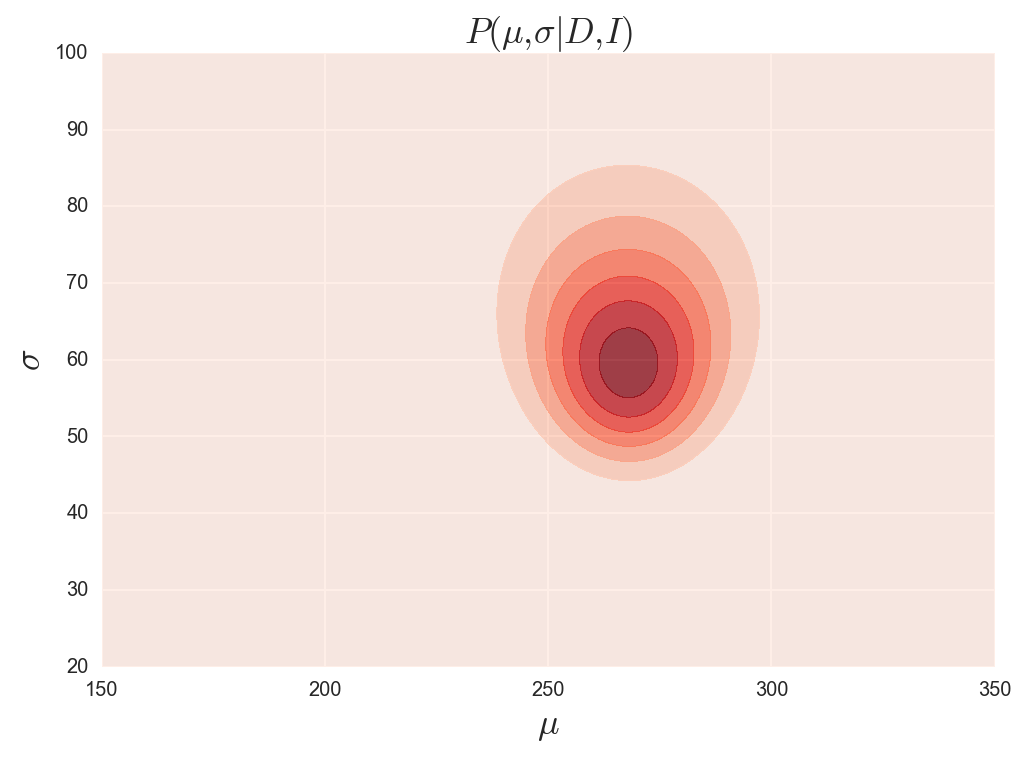

In [125]:
# Use contourf with Reds colormap.
plt.contourf(mu, sigma, np.exp(log_post_gaussian), cmap=plt.cm.Reds, alpha=0.75)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'$P(\mu,\sigma|D,I)$');

In [90]:
# Approximate most probable value of mu and sigma
most_prob_inds = np.unravel_index(log_post_gaussian.argmax(), log_post_gaussian.shape)
mu_most_prob = mu[most_prob_inds[1]]
sigma_most_prob = sigma[most_prob_inds[0]]

print('most probable mu    = {0:.3f}'.format(mu_most_prob))
print('most probable sigma = {0:.3f}'.format(sigma_most_prob))

most probable mu    = 267.588
most probable sigma = 59.397


Compared to the posterior generated from a, uniform prior, this posterior favors slightly smaller mus and sigmas. This makes sense because the mean of the gaussian prior is less than the most probable value of mu calculated with a flat prior for mu. 

## 2.2e Another Gaussian prior for mu

In [126]:
log_post_gaussian2 = log_posterior(log_likelihood, log_prior_gaussian, sleep_minutes, mu, sigma, ranges,m=225,s=20)

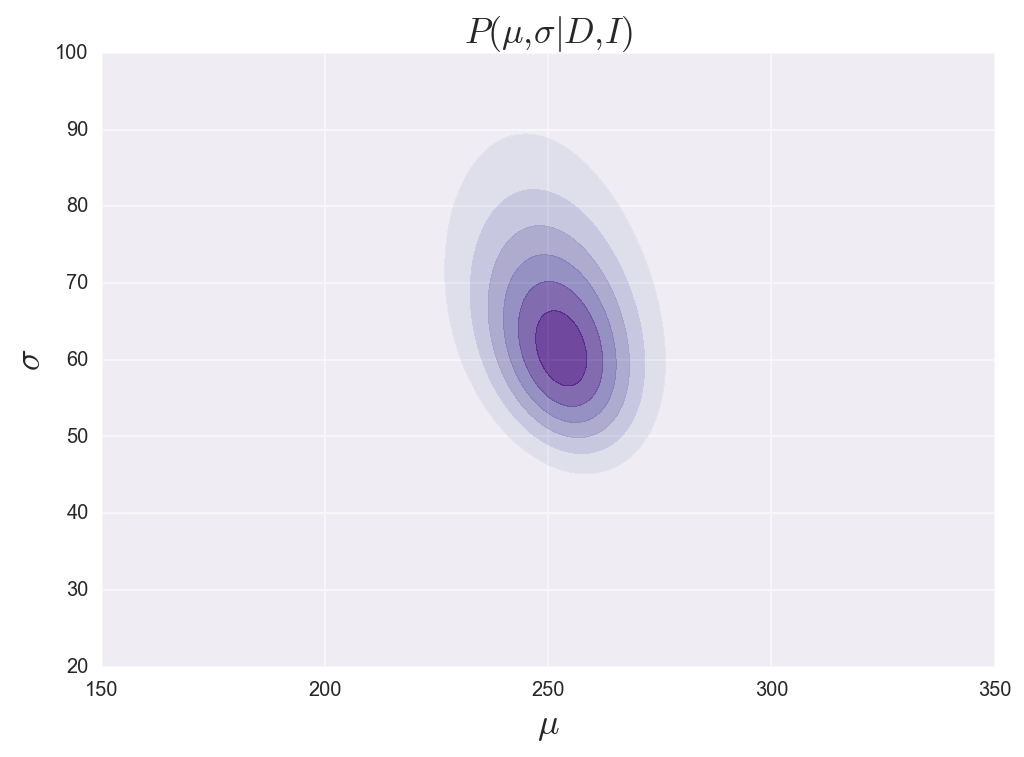

In [128]:
# Use contourf with Purples colormap.
plt.contourf(mu, sigma, np.exp(log_post_gaussian2), cmap=plt.cm.Purples, alpha=0.75)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'$P(\mu,\sigma|D,I)$');

In [131]:
# Approximate most probable value of mu and sigma
most_prob_inds = np.unravel_index(log_post_gaussian2.argmax(), log_post_gaussian2.shape)
mu_most_prob = mu[most_prob_inds[1]]
sigma_most_prob = sigma[most_prob_inds[0]]

print('most probable mu    = {0:.3f}'.format(mu_most_prob))
print('most probable sigma = {0:.3f}'.format(sigma_most_prob))

most probable mu    = 253.518
most probable sigma = 61.005


Counter-intuitively, setting a smaller standard deviation for the prior for mu skews the posterior distribution. The most probable value for mu is less than it was for any of the other priors (because the mean of the prior is less than the mean of the post found using a flat prior for mu, and the smaller standard deviation for the prior for mu penalizes larger values of mu), and the most probable sigma is as high as for the uniform prior. 